In [69]:
%load_ext autoreload
%autoreload 2

%config IPCompleter.greedy=True

# Stellar mass vs. $v_\text{max}$

First, imports:

In [70]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from astropy import units
from pathlib import Path
import os

import snapshot_obj
import dataset_compute
import trace_halo

import importlib

In [71]:
importlib.reload(snapshot_obj)
importlib.reload(dataset_compute)
importlib.reload(trace_halo)

<module 'trace_halo' from '/home/kasper/Curvaton_Simulations/APOSTLE_analysis/trace_halo.py'>

## Get data

In [76]:
sim_id = "CDM_V1_LR"
start = 127; stop = 110
data = {}
for snap_id in range(start,stop-1,-1):
    snap = snapshot_obj.Snapshot(sim_id, snap_id)
    
    vmax = snap.get_subhalos("Vmax") / 100000 # cm/s to km/s 
    SM = snap.get_subhalos("Stars/Mass") * units.g.to(units.Msun)

    data[snap_id] = (vmax,SM)

# Trace halos

In [74]:
snap_start = snapshot_obj.Snapshot(sim_id, start)
tracer = trace_halo.trace_all(snap_start, stop=stop)

In [110]:
evol_lines = {}
for idx_start, halo_snaps in enumerate(tracer):
    if len(halo_snaps) >= 10:
        vmax_evol = []; sm_evol = []
        for instance in halo_snaps:
            snap_id, idx = instance
            if not idx is None:
                vmax_at_snap = data[snap_id][0][idx]
                sm_at_snap = data[snap_id][1][idx]
                vmax_evol += [vmax_at_snap]
                sm_evol += [sm_at_snap]
        evol_lines[idx_start] = (np.array(vmax_evol), np.array(sm_evol))

In [138]:
# Only follow luminous (MW or M31) satellites that end up as satellites:
gns_start = snap_start.get_subhalos("GroupNumber")
sgns_start = snap_start.get_subhalos("SubGroupNumber")
vmax_start, sm_start = data[start]

gn=2
mask = np.logical_and.reduce((gns_start==gn, sgns_start!=0, vmax_start>0, sm_start>0))

choose = [key for key in evol_lines.keys() if mask[key]]
these = {key : evol_lines.get(key) for key in choose}

## Plot

In [139]:
# Set some parameters:
x_down = 10; x_up = 100
y_down = 10**5; y_up = 5*10**9

No handles with labels found to put in legend.


9


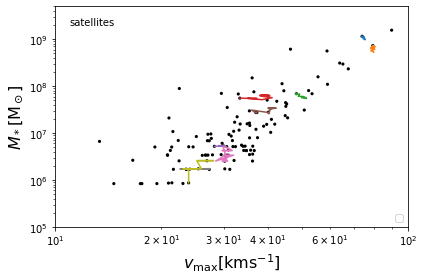

In [140]:
fig, axes = plt.subplots()

# Set axes:
axes.set_xscale('log')
axes.set_yscale('log')
axes.set_xlim(x_down,x_up)
axes.set_ylim(y_down,y_up)

# Set labels:
axes.set_xlabel('$v_{\mathrm{max}}[\mathrm{km s^{-1}}]$', fontsize=16)
axes.set_ylabel('$M_*[\mathrm{M_\odot}]$', fontsize=16)
axes.text(11, 2*10**9, 'satellites')
#axes.set_title('Stellar mass of satellites')
#axes.text(11, 2*10**9, 'isolated galaxies')
#axes.set_title('Stellar mass of isolated galaxies')

# Set marker styles:
color = {stop : "blue", start : "black"}

print(len(these.keys()))
for line in these.values():
    axes.plot(line[0], line[1])
    
# start scatter plot:
axes.scatter(data[start][0], data[start][1], c=color[start], \
        edgecolor='none', s=10)

axes.legend(loc='lower right')
plt.tight_layout()

# Save figure:

filename = 'SM_vs_Vmax_sat_evol_gn{}.png'.format(gn)
#filename = 'SM_vs_Vmax_isol.png'

home = os.path.dirname(snapshot_obj.__file__)
path = os.path.join(home,"Figures")

# If the directory does not exist, create it
if not os.path.exists(path):
    os.makedirs(path)
plt.savefig(os.path.join(path,filename), dpi=300)